In [1]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from UQpy.surrogates import *
from UQpy.distributions import Uniform, JointIndependent
from sklearn.linear_model import Lars
from PC_PCE import *

In [2]:


def Heat_Eq(e_num, alpha, t_final):
    """
    This function simulates the heat equation using the FEniCS library.
    It solves the heat equation on a 2D unit square with initial condition as a sum of sine functions.
    The function uses a finite element method with linear elements (P1) and a given time step size.

    Parameters:
    e_num (int): The number of elements along each dimension of the mesh.
        Increasing this value increases the resolution of the mesh.
    alpha (float): The diffusion coefficient.
    t_final (float): The final time for the simulation.

    Returns:
    np.ndarray: A 2D numpy array containing the temperature profile at each time step.
        The shape of the array is (num_steps, enum * enum), where num_steps is the number of time steps.
    """

    # Create mesh and define function space
    mesh = RectangleMesh(Point(0, 0), Point(1, 1), e_num-1, e_num-1)  # Increased resolution
    V = FunctionSpace(mesh, 'P', 1)

    # Define initial condition
    u0_expr = Expression('0.5*sin(4*pi*x[0])+0.5*sin(4*pi*x[1])', degree=2)
    u0 = interpolate(u0_expr, V)

    # Define boundary conditions
    # def boundary(x, on_boundary):
        # return on_boundary

    # bc = DirichletBC(V, Constant(0), boundary)

    # Define variational problem
    u = TrialFunction(V)
    v = TestFunction(V)
    T = t_final
    num_steps = 100  # Number of time steps
    dt = T / num_steps  # Time step size

    a = u * v * dx + dt * alpha * dot(grad(u), grad(v)) * dx
    L = u0 * v * dx
    temp_profile = np.zeros([num_steps, e_num*e_num])

    # Time-stepping
    u = Function(V)
    t = 0
    for n in range(num_steps):
        t += dt
        solve(a == L, u)
        u0.assign(u)
        temp = u.compute_vertex_values(mesh)
        temp_profile[n, :] = temp

    return temp_profile



In [3]:
def constrained_PCE(Multindex, polynomial, x_v, x_v_IC, x_v_BC, lb, ub, *data):
    """
    Perform physics constrained polynomial chaos expansion. Tweak this function based on the given constraints.

    Parameters:
    Multindex (numpy.ndarray): A 2D numpy array containing the multivariate indices.
    polynomial (list): A list of strings representing the type of polynomial for each variable.
    x_v (numpy.ndarray): A 2D numpy array containing the virtual collocation points for the PDE.
    x_v_IC (numpy.ndarray): A 2D numpy array containing the virtual collocation points for the initial condition.
    x_v_BC (numpy.ndarray): A 3D numpy array containing the virtual collocation points for the boundary conditions.
    lb (numpy.ndarray): A 1D numpy array containing the lower bounds for each variable for Uniform distribution and means for Normal distribution.
    ub (numpy.ndarray): A 1D numpy array containing the upper bounds for each variable for Uniform distribution and standard deviations for Normal distribution.
    *data (tuple): Training data for the PDE, if available.

    Returns:
    coeff (numpy.ndarray): The coefficients of the PC^2 expansion.
    res.fun (float): The value of the cost function at the optimal solution.
    """
    
    if len(data) > 0:
        Y = data[0][:,-1].reshape(-1, 1)
        X = data[0][:,:-1]
        Basis = PolynomialBasisDerivative(Multindex, polynomial, X, lb, ub)
    else:
        Y = None
        Basis = None
    
    Basis_u_t = PolynomialBasisDerivative(Multindex, polynomial, x_v, lb, ub, dimension=2, order=1)
    Basis_u_xx = PolynomialBasisDerivative(Multindex, polynomial, x_v, lb, ub, dimension=0, order=2)
    Basis_u_yy = PolynomialBasisDerivative(Multindex, polynomial, x_v, lb, ub, dimension=1, order=2)
    
    Basis_u_IC = PolynomialBasisDerivative(Multindex, polynomial, x_v_IC, lb, ub)
    Basis_u_BC1 = PolynomialBasisDerivative(Multindex, polynomial, x_v_BC[:,:,0], lb, ub, dimension=0, order=1)
    Basis_u_BC2 = PolynomialBasisDerivative(Multindex, polynomial, x_v_BC[:,:,1], lb, ub, dimension=0, order=1)
    Basis_u_BC3 = PolynomialBasisDerivative(Multindex, polynomial, x_v_BC[:,:,2], lb, ub, dimension=1, order=1)
    Basis_u_BC4 = PolynomialBasisDerivative(Multindex, polynomial, x_v_BC[:,:,3], lb, ub, dimension=1, order=1)
    
    def compute_loss_component(loss, num_points, threshold=1e-9):
        mask = np.logical_not(np.isclose(loss, 0, atol=threshold))
        return np.sum(loss**2 * mask.astype(int)) / num_points
            
    def cost(Y, u):
        Y_t = Basis_u_t @ u.T.reshape(-1, 1)
        Y_xx = Basis_u_xx @ u.T.reshape(-1, 1)
        Y_yy = Basis_u_yy @ u.T.reshape(-1, 1)

        # PDE loss:
        loss_u = Y_t -  (0.01) * (Y_xx + Y_yy)
        
        # Initial condition loss:
        loss_IC = Basis_u_IC @ u.T.reshape(-1, 1) - (0.5 * np.sin(4 * np.pi * x_v_IC[:,0].reshape(-1, 1)) + 0.5 * np.sin(4 * np.pi * x_v_IC[:,1].reshape(-1, 1)))
    
        # Boundary condition loss:
        loss_BC1 = Basis_u_BC1 @ u.T.reshape(-1, 1)
        loss_BC2 = Basis_u_BC2 @ u.T.reshape(-1, 1)
        loss_BC3 = Basis_u_BC3 @ u.T.reshape(-1, 1)
        loss_BC4 = Basis_u_BC4 @ u.T.reshape(-1, 1)
        
        # Compute l0 if data is provided, otherwise set l0 to 0
        l0 = (np.sum((Y - Basis @ u.T.reshape(-1, 1))**2, axis=0) / Basis.shape[0]) if len(data) > 0 else 0

        # Compute loss components
        l1 = compute_loss_component(loss_u, x_v.shape[0])                     # PDE loss  
        l2 = compute_loss_component(loss_IC, x_v_IC.shape[0])                 # Initial condition loss  
        l3 = compute_loss_component(loss_BC1, x_v_BC[:,:,0].shape[0])         # Boundary condition loss 1  
        l4 = compute_loss_component(loss_BC2, x_v_BC[:,:,1].shape[0])         # Boundary condition loss 2  
        l5 = compute_loss_component(loss_BC3, x_v_BC[:,:,2].shape[0])         # Boundary condition loss 3 
        l6 = compute_loss_component(loss_BC4, x_v_BC[:,:,3].shape[0])         # Boundary condition loss 4 
        
        # Adaptive weighting scheme
        w0 = l0 / (l0 + l1 + l2 + l3 + l4 + l5 + l6)
        w1 = l1 / (l0 + l1 + l2 + l3 + l4 + l5 + l6)
        w2 = l2 / (l0 + l1 + l2 + l3 + l4 + l5 + l6)
        w3 = l3 / (l0 + l1 + l2 + l3 + l4 + l5 + l6)
        w4 = l4 / (l0 + l1 + l2 + l3 + l4 + l5 + l6)
        w5 = l5 / (l0 + l1 + l2 + l3 + l4 + l5 + l6)
        w6 = l6 / (l0 + l1 + l2 + l3 + l4 + l5 + l6)
        
        c = w0 * l0 + w1 * l1 + w2 * l2 + w3 * l3 + w4 * l4 + w5 * l5 + w6 * l6
        
        return c
    
    def costfunction(u):
        return cost(Y, u)
    
    u0 = np.zeros((Multindex.shape[0]))
    
    def callback(xk):
        print(f"Iteration: {callback.nfev}")
        print(f"Current solution: {costfunction(xk)}")
        callback.nfev += 1

    callback.nfev = 0
    res = minimize(costfunction, u0, callback=callback, method='BFGS', options={'ftol': 1e-9, 'maxiter': 500, 'maxfun': 1000, 'maxls': 50, 'disp': True}) # adjust the options as needed
    u = res.x
    coeff = u

    return coeff, res.fun


In [4]:
def sparse_PC2(Multindex, PolynomialType, x_v, x_v_IC, x_v_BC, lb, ub, data, target_error, steps):
    """
    Perform sparse physics-constrained polynomial chaos (PC^2) expansion using the LARS algorithm.
    
    Parameters:
    Multindex (numpy.ndarray): A 2D numpy array containing the multivariate indices.
    PolynomialType (list): A list of strings representing the type of polynomial for each variable.
    x_v (numpy.ndarray): A 2D numpy array containing the virtual collocation points for the PDE.
    x_v_IC (numpy.ndarray): A 2D numpy array containing the virtual collocation points for the initial condition.
    x_v_BC (numpy.ndarray): A 3D numpy array containing the virtual collocation points for the boundary conditions.
    lb (numpy.ndarray): A 1D numpy array containing the lower bounds for each variable for Uniform distribution and means for Normal distribution.
    ub (numpy.ndarray): A 1D numpy array containing the upper bounds for each variable for Uniform distribution and standard deviations for Normal distribution.
    data (numpy.ndarray): A 2D numpy array containing the training data.
    target_error (float): The target error for the sparse PC^2 solution.
    steps (list): A list of integers representing the number of influential polynomials to select.
    
    Returns:
    coeff (numpy.ndarray): The coefficients of the sparse PC^2 expansion.
    sparse_multi_index (numpy.ndarray): The multivariate indices of the selected polynomial basis.
    """
    
    Y = data[:,-1].reshape(-1, 1)
    X = data[:,:-1]
    Basis = PolynomialBasisDerivative(Multindex, PolynomialType, X, lb, ub, dimension=0, order=0)

    for n in steps:
        
        print(n)
        
        lars = Lars(fit_intercept=False, n_nonzero_coefs=n, normalize=False)  # Set the number of polynomial basis you want to select
        lars.fit(Basis, np.squeeze(Y))
        all_coefficients = lars.coef_
        sorted_indices = sorted(range(len(all_coefficients)), key=lambda k: abs(all_coefficients[k]), reverse=True)
        selected_features = sorted_indices[:n]  # Select the top k polynomial basis
        sparse_multi_index = Multindex[selected_features]
        coeff, rr = constrained_PCE(sparse_multi_index, PolynomialType, x_v, x_v_IC, x_v_BC, lb, ub, data)
        if rr < target_error:
            break
    
    return coeff, sparse_multi_index

In [5]:
def PC2_deter_solution(Multindex, PolynomialType, x_v, x_v_IC, x_v_BC, lb, ub, x_test, solution_type, *args):
    """
    Physics-Constrained Polynomial Chaos (PC^2) deterministic solution for a given problem.

    Parameters:
    Multindex (numpy.ndarray): A 2D numpy array containing the multivariate indices.
    PolynomialType (list): A list of strings representing the type of polynomial for each variable.
    x_v (numpy.ndarray): A 2D numpy array containing the virtual collocation points for the PDE.
    x_v_IC (numpy.ndarray): A 2D numpy array containing the virtual collocation points for the initial condition.
    x_v_BC (numpy.ndarray): A 3D numpy array containing the virtual collocation points for the boundary conditions.
    lb (numpy.ndarray): A 1D numpy array containing the lower bounds for each variable for Uniform distribution and means for Normal distribution.
    ub (numpy.ndarray): A 1D numpy array containing the upper bounds for each variable for Uniform distribution and standard deviations for Normal distribution.
    x_test (numpy.ndarray): A 2D numpy array containing the test points for evaluating the PC^2 solution.
    solution_type (str): A string indicating the type of PC^2 solution ('Sparse' or 'Full').
    *args: Additional arguments for the PC^2 solution. If solution_type is 'Sparse', provide additional arguments as data, target_error, and steps. 
    * If solution_type is 'Full', provide additional arguments as data (if available). 

    Returns:
    y_PC2 (numpy.ndarray): The PC^2 solution evaluated at the test points.

    """


    if solution_type == 'Sparse':
        if len(args)<3:
            raise ValueError("Invalid argument for Sparse PC^2 solution type. Provide additional arguments as data, target_error, and steps.")

        coeff_sparse, multindex_sparse = sparse_PC2(Multindex, PolynomialType, x_v, x_v_IC, x_v_BC, lb, ub, args[0], args[1], args[2])
        y_PC2 = PolynomialBasisDerivative(multindex_sparse, PolynomialType, x_test, lb, ub, dimension=0, order=0)@coeff_sparse.T
        
    elif solution_type == 'Full':
        
        if len(args)>0:            # with data
            coeff, _ = constrained_PCE(Multindex, PolynomialType, x_v, x_v_IC, x_v_BC, lb, ub, args[0])
        else:                      # without data
            coeff, _ = constrained_PCE(Multindex, PolynomialType, x_v, x_v_IC, x_v_BC, lb, ub)
            
        y_PC2 = PolynomialBasisDerivative(Multindex, PolynomialType, x_test, lb, ub, dimension=0, order=0)@coeff.T

    else:
        raise ValueError("Invalid argument for PC^2 solution type. Use 'Sparse' or 'Full'.")
        
    return y_PC2
        
    

In [6]:
# FEM solution for the heat equation
e_num = 100
alpha = 0.01
t_final = 1

temperature_matrix = Heat_Eq( e_num, alpha, t_final)
U = temperature_matrix.reshape(100, 100, -1)   

# Data generation
count = 746 # number of training data points
data = model(U, count)

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

In [7]:
# PCE setup
PCEorder = 10
nvar=3;
lb = np.array([0,0,0])
ub = np.array([1,1,1])
X_train = data[:,0:3]
y_train = data[:,3].reshape(-1,1)      
PolynomialType=['Legendre']*nvar
least_squares = LeastSquareRegression()
dist1 = Uniform(0,1)   
dist2 = Uniform(0,1)
dist3 = Uniform(0,1)  
marg = [dist1, dist2, dist3]
joint = JointIndependent(marginals=marg)
polynomial_basis = TotalDegreeBasis(joint, PCEorder)

pce = PolynomialChaosExpansion(polynomial_basis=polynomial_basis, regression_method=least_squares)
pce.fit(X_train, y_train)


In [8]:
# Select the number of virtual collocation points for each type
n_v_IC = 200
n_v_BC = 200
n_v = 5000

# Generate Latin Hypercube Samples (LHS) for virtual collocation points associated with initial conditions (IC) and boundary conditions (BC)
x_v_IC = generate_lhs_samples(lb, ub, n_v_IC, fixed_dimension=2, fixed_value=0)

boundary_conditions = [(0, 0), (0, 1), (1, 0), (1, 1)]
x_v_BC = np.stack([generate_lhs_samples(lb, ub, n_v_BC, fixed_dimension=dim, fixed_value=val)
                   for dim, val in boundary_conditions], axis=-1)

# Generate LHS samples for the virtual collocation points associated with the domain
x_v = generate_lhs_samples(lb, ub, n_v, fixed_dimension=[], fixed_value=[])

# Generate test points
x_test = np.array([[x, y, z] for z in np.linspace(0, 1, num=100) for x in np.linspace(0, 1, num=100) for y in np.linspace(0, 1, num=100)])


In [9]:
# Sparse PC^2 parameters
target_error = 0.008    # adjust the target error based on the given problem
P, _ = pce.multi_index_set.shape
steps = np.linspace(100, P, 5, dtype=int)   # adjust the number of steps based on the given problem
    

In [10]:
y_PC2 = PC2_deter_solution(pce.multi_index_set, PolynomialType, x_v, x_v_IC, x_v_BC, lb, ub, x_test, 'Sparse', data, target_error, steps)

100
Iteration: 0
Current solution: [0.11736055]
Iteration: 1
Current solution: [0.11635182]
Iteration: 2
Current solution: [0.11469824]
Iteration: 3
Current solution: [0.11194935]
Iteration: 4
Current solution: [0.10813255]
Iteration: 5
Current solution: [0.10556212]
Iteration: 6
Current solution: [0.10457073]
Iteration: 7
Current solution: [0.10402875]
Iteration: 8
Current solution: [0.10306564]
Iteration: 9
Current solution: [0.10162267]
Iteration: 10
Current solution: [0.10104222]
Iteration: 11
Current solution: [0.10071198]
Iteration: 12
Current solution: [0.10056437]
Iteration: 13
Current solution: [0.1003353]
Iteration: 14
Current solution: [0.1000159]
Iteration: 15
Current solution: [0.09991421]
Iteration: 16
Current solution: [0.09973447]
Iteration: 17
Current solution: [0.09942456]
Iteration: 18
Current solution: [0.09906148]
Iteration: 19
Current solution: [0.09873754]
Iteration: 20
Current solution: [0.09839302]
Iteration: 21
Current solution: [0.09810896]
Iteration: 22
Curr

In [11]:
# Compute the Mean Squared Error for the entire domain
y_PC2 = y_PC2.reshape(100,100, 100) 
MSE = np.mean((y_PC2-U)**2)
print('Mean Squared Error for the entire domain:', MSE)

Mean Squared Error for the entire domain: 8.603151224976439e-05


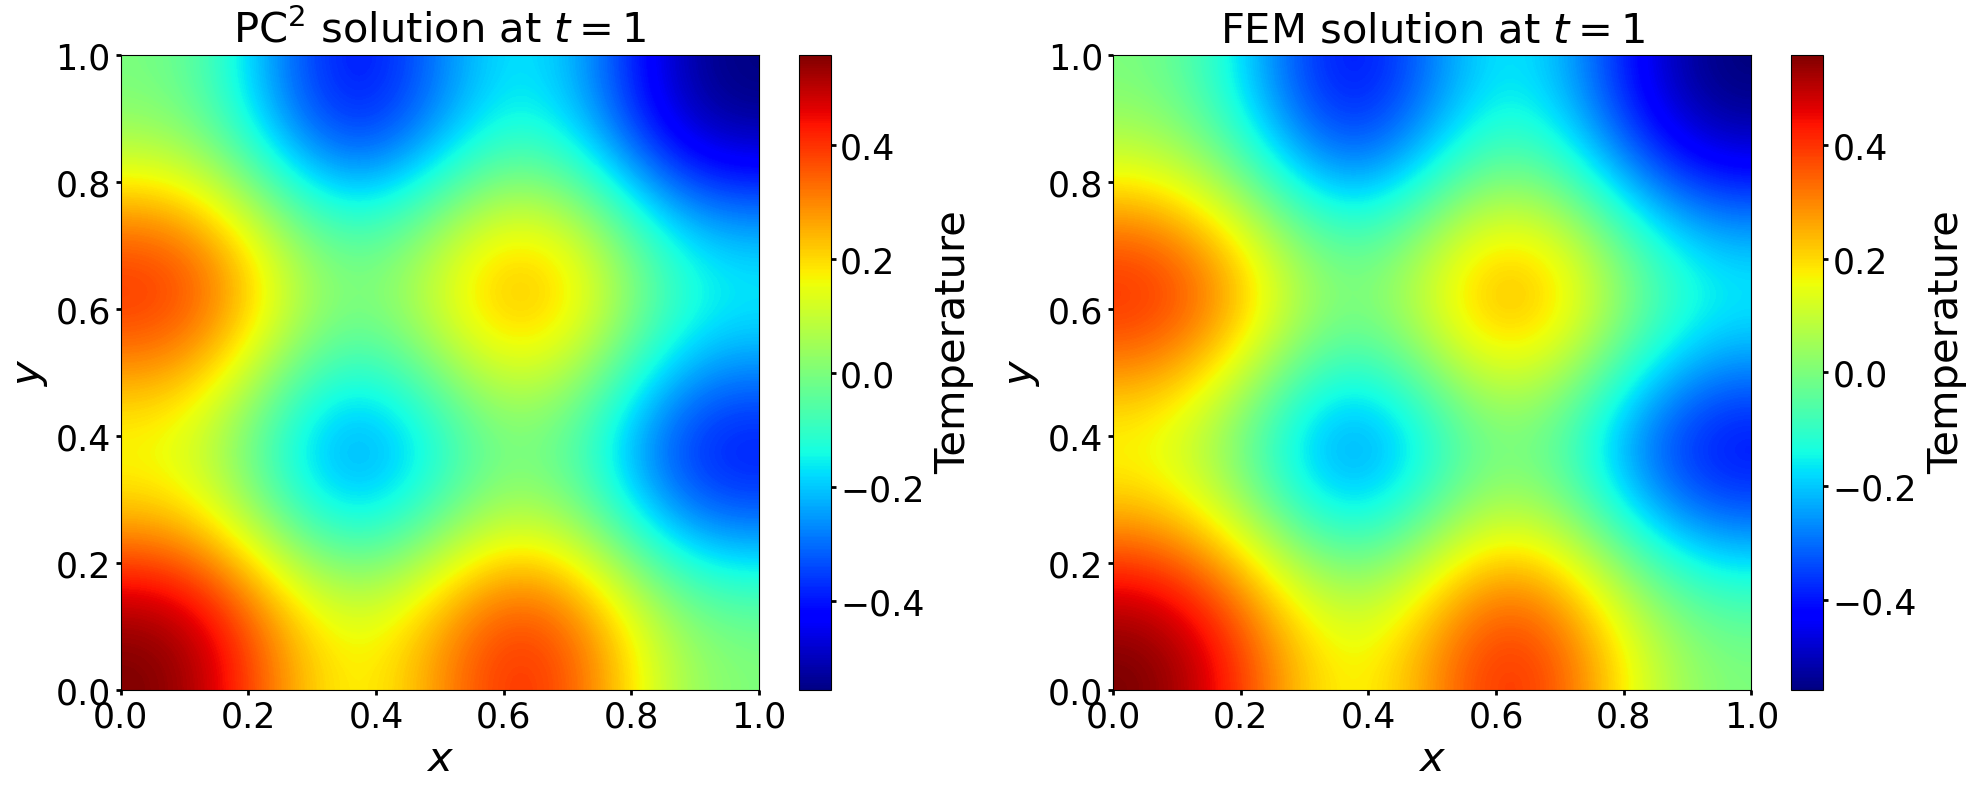

In [12]:
# Plot the temperature distribution at t=1 using PC2 solution and FEM solution
x = np.linspace(0, 1, U.shape[0])
y = np.linspace(0, 1, U.shape[1])

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Plot for PC2 solution
CS1 = axs[0].contourf(x, y, y_PC2[-1, :, :], 500, cmap="jet", vmin=-0.56, vmax=0.56)
axs[0].set_ylabel(r'$y$', fontsize=30)
axs[0].set_xlabel(r'$x$', fontsize=30)
axs[0].tick_params(labelsize=25, colors='black', width=2)
axs[0].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
axs[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
axs[0].set_title(r'$\mathrm{PC}^2$ solution at $t=1$', fontsize=30, pad=10)
cbar1 = plt.colorbar(CS1, ax=axs[0], ticks=[-0.4, -0.2, 0, 0.2, 0.4])
cbar1.set_label(r'Temperature', fontsize=30, labelpad=7, rotation=90, y=0.55)
cbar1.ax.tick_params(axis='y', labelsize=25, colors='black', width=2)

# Plot for FEM solution
CS2 = axs[1].contourf(x, y, U[-1, :, :], 500, cmap="jet", vmin=-0.56, vmax=0.56)
axs[1].set_ylabel(r'$y$', fontsize=30)
axs[1].set_xlabel(r'$x$', fontsize=30)
axs[1].tick_params(labelsize=25, colors='black', width=2)
axs[1].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
axs[1].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
axs[1].set_title(r'FEM solution at $t=1$', fontsize=30, pad=10)
cbar2 = plt.colorbar(CS2, ax=axs[1], ticks=[-0.4, -0.2, 0, 0.2, 0.4])
cbar2.set_label(r'Temperature', fontsize=30, labelpad=7, rotation=90, y=0.55)
cbar2.ax.tick_params(axis='y', labelsize=25, colors='black', width=2)

plt.tight_layout()
plt.show()
